# FlexzBoost on cosmoDC2 gold test set

<span style="font-size:22px;"> Author: Iago Lopes Soares Dias<br>
Email: iagolops2012@gmail.com</span>


In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables_io
import qp
import sys


from matplotlib import gridspec
import seaborn as sns
from qp.metrics.pit import PIT
from IPython.display import Markdown
import h5py
import os
from qp.ensemble import Ensemble
from qp import interp


from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator
from rail.evaluation.metrics.base import MetricEvaluator
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle, DataHandle
from rail.core.util_stages import ColumnMapper, TableConverter
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.point_est_hist import PointEstHistSummarizer

import warnings
warnings.filterwarnings("ignore")


## Reading data

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [70]:
t = tables_io.read('/home/iago.dias/cosmodc2_140k_gold_testset.hdf5')

In [71]:
data = pd.DataFrame(t['photometry'])

In [72]:
data

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
0,0.670420,0.007072,1312500000,0.193890,0.007071,0.005001,0.005000,0.005000,0.005026,0.005001,...,17.491247,14.687290,14.804871,0.015425,0.354918,0.007071,1.467150,0.007090,0.117580,0.007072
1,0.315699,0.007944,1312500225,0.077675,0.008477,0.005824,0.005575,0.005403,0.033321,0.009905,...,23.202431,21.592501,21.638060,0.030609,0.185198,0.007763,0.985800,0.033827,0.045559,0.011785
2,0.174147,0.033231,1312500450,0.122187,0.047875,0.026059,0.025786,0.020620,0.306728,0.097963,...,25.644894,24.262041,24.195457,0.045475,0.147116,0.033017,1.005987,0.307833,-0.066584,0.105942
3,0.275715,0.013911,1312500675,0.048395,0.018623,0.010965,0.010116,0.008561,0.123833,0.032323,...,24.655771,23.041840,23.107073,0.065590,0.142187,0.013252,1.082401,0.124318,0.065233,0.035906
4,0.434650,0.056377,1312500900,0.127439,0.064814,0.047869,0.034883,0.029781,0.498633,0.127012,...,26.173477,24.545084,24.529957,0.065404,0.227051,0.045866,0.854380,0.500925,-0.015127,0.138261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141348,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,0.129267,...,24.674099,24.564243,24.624903,2.557191,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
141349,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,0.164621,...,24.415499,24.827410,24.705545,2.616157,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
141350,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,0.114559,...,25.356873,24.432663,24.294462,2.694391,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759
141351,0.125515,0.055764,12019512222,0.238531,0.079680,0.043097,0.045896,0.035388,26.620825,0.198862,...,99.000000,25.032970,24.722982,2.877230,0.115925,0.057954,73.797043,26.620859,-0.309988,0.209257


## Removing mag 99 and bright objects

In [73]:
bands = ['u','g','r','i','z','y']
limits = []
for band in bands:
    data = data[data[f'mag_{band}_lsst']<99]
    data = data[data[f'mag_{band}_lsst']>16]
    limits.append(max(data[f'mag_{band}_lsst']))

In [83]:
np.round(limits,4)

array([34.824 , 29.6312, 26.9223, 25.    , 25.3282, 26.1534])

In [74]:
data

,gr,gr_err,id,iz,iz_err,mag_err_g_lsst,mag_err_i_lsst,mag_err_r_lsst,mag_err_u_lsst,mag_err_y_lsst,...,mag_u_lsst,mag_y_lsst,mag_z_lsst,redshift,ri,ri_err,ug,ug_err,zy,zy_err
1,0.315699,0.007944,1312500225,0.077675,0.008477,0.005824,0.005575,0.005403,0.033321,0.009905,...,23.202431,21.592501,21.638060,0.030609,0.185198,0.007763,0.985800,0.033827,0.045559,0.011785
2,0.174147,0.033231,1312500450,0.122187,0.047875,0.026059,0.025786,0.020620,0.306728,0.097963,...,25.644894,24.262041,24.195457,0.045475,0.147116,0.033017,1.005987,0.307833,-0.066584,0.105942
3,0.275715,0.013911,1312500675,0.048395,0.018623,0.010965,0.010116,0.008561,0.123833,0.032323,...,24.655771,23.041840,23.107073,0.065590,0.142187,0.013252,1.082401,0.124318,0.065233,0.035906
4,0.434650,0.056377,1312500900,0.127439,0.064814,0.047869,0.034883,0.029781,0.498633,0.127012,...,26.173477,24.545084,24.529957,0.065404,0.227051,0.045866,0.854380,0.500925,-0.015127,0.138261
5,0.409700,0.014604,1312501125,0.089149,0.016855,0.011905,0.009458,0.008458,0.155537,0.028244,...,24.904810,22.890232,22.965204,0.052629,0.222832,0.012689,1.217924,0.155992,0.074972,0.031501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141347,0.306469,0.057675,12016611194,-0.171865,0.091578,0.047302,0.039958,0.032999,3.383940,0.170498,...,28.253912,24.865582,24.980207,2.537769,0.191120,0.051823,2.947981,3.384271,0.114626,0.189366
141348,0.029175,0.033723,12016630894,-0.040840,0.067929,0.025100,0.032665,0.022522,0.125926,0.129267,...,24.674099,24.564243,24.624903,2.557191,-0.017170,0.039677,0.078032,0.128403,0.060659,0.142328
141349,-0.101969,0.027431,12017441655,-0.119417,0.071975,0.019350,0.032725,0.019444,0.099430,0.164621,...,24.415499,24.827410,24.705545,2.616157,-0.190060,0.038066,0.121399,0.101296,-0.121864,0.176662
141350,0.147083,0.029719,12018021781,0.005085,0.050893,0.023071,0.025379,0.018733,0.235440,0.114559,...,25.356873,24.432663,24.294462,2.694391,0.052650,0.031544,0.857592,0.236568,-0.138201,0.122759


## Functions

In [97]:
def plot_redshift(catalog):
    plt.figure(figsize=(8,8))
    plt.hist(catalog['redshift'],bins=201,density=True,color='red')
    plt.xlabel('Redshift', fontsize=13)
    plt.ylabel('Normalized Counts', fontsize=13)
    plt.show()

In [23]:
def plot_errors(catalog):
    bands = ['u', 'g', 'r', 'i', 'z', 'y']
    j=1
    plt.figure(figsize=[9,13])
    for i, band in enumerate(bands):

        plt.subplot(3,2,j) 
        mag = np.array(catalog[f'mag_{band}_lsst'])
        err = np.array(catalog[f'mag_err_{band}_lsst'])
        sn = 1/(10**(0.4*err)-1)
        plt.hexbin(mag,sn , None, mincnt=1, cmap='inferno', gridsize=[400,200], bins='log')
        cbar = plt.colorbar()
        plt.ylabel("S/R ", fontsize=13)
        plt.xlabel("mag "+band, fontsize=13)
        plt.ylim(0,100)
        plt.xlim(20,30)
        plt.axhline(10, color= 'red')
        plt.grid(True)
        j+=1
        plt.tight_layout()

In [15]:
def mag_histogram(catalog, title='DP0.2'):
    
    bands = ['u','g', 'r', 'i', 'z','y']
    colors = ['blue', 'green', 'orange','red','purple','gray']
    plt.figure(figsize=(9,13))
    bins = np.linspace(9, 37, 57)
    j=1
    for i, (band, color) in enumerate(zip(bands,colors)):
        plt.subplot(3,2,j)
        plt.hist(catalog[f'mag_{band}_lsst'], histtype='stepfilled', bins=bins, label=f'{band} band', alpha = 0.5,
                 edgecolor = "black", color = color)
        #plt.xlim(16,27)
        plt.yscale('log')
        plt.xlabel('mag',fontsize=13)
        plt.ylabel('counts',fontsize=13)
        plt.legend(loc=2)
        plt.grid(True)
        j+=1
    plt.suptitle(title)
    plt.show()


In [61]:
def mag_color(catalog):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    mag_diff = {}
    plt.figure(figsize=(9,13))
    i=1
    for band,_band in zip(bands, bands[1::]):
        plt.subplot(3,2,i)
        i+=1
        mag_diff_v = catalog[f'mag_{band}_lsst']-catalog[f'mag_{_band}_lsst']
        mag_v = catalog[f'mag_{band}_lsst'] 
                   
        plt.hexbin(mag_v, mag_diff_v, None, mincnt=1, cmap='Reds', gridsize=[400,400], bins='log')

        plt.xlabel("mag "+band,fontsize=13)
        plt.ylabel(f"{band}-{_band}",fontsize=13)
        #plt.legend()
        plt.xlim(16,32)
        plt.ylim(-2,5)
        plt.grid(True)
        plt.tight_layout()
    plt.show()

In [17]:
def cor_cor(catalog):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        plt.hist2d(past_color-color,color-next_color, bins = 100, cmap='turbo' )
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        #plt.axvline(0)
        #plt.axhline(0)
    plt.show()

In [59]:
def color_color(catalog):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(past_color-color,color-next_color, None, mincnt=1, cmap='turbo', gridsize=[400,400], bins='log')
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar()
        plt.xlim(-1,3)
        plt.ylim(-1,3)
    plt.show()

In [60]:
def color_color_red(catalog,xlim=[-1,3],ylim=[-1,3]):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(past_color-color,color-next_color, C=catalog['redshift'], mincnt=1, cmap='turbo', gridsize=[400,200])
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar(label='redshift')
        plt.xlim(xlim[0],xlim[1])
        plt.ylim(ylim[0],ylim[1])
    plt.show()

## Plots

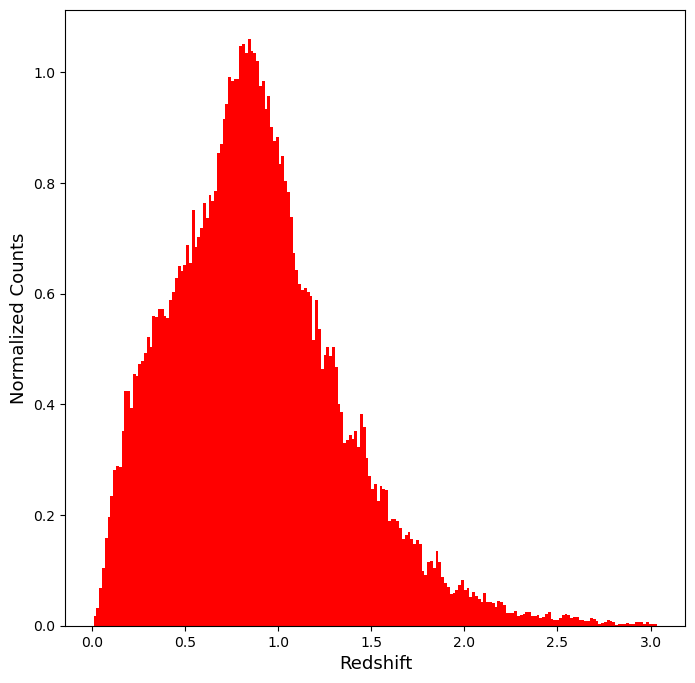

In [98]:
plot_redshift(data)

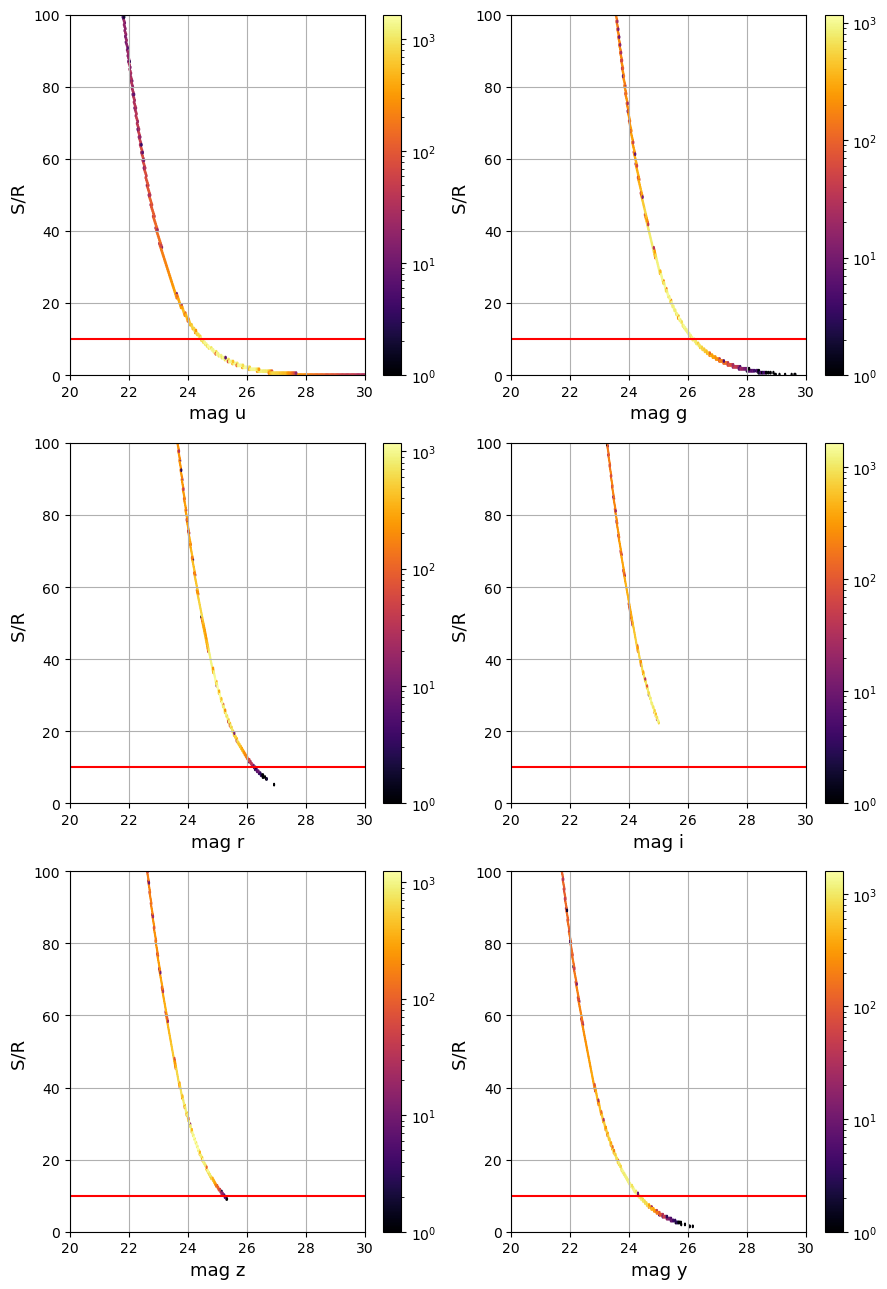

In [75]:
plot_errors(data)

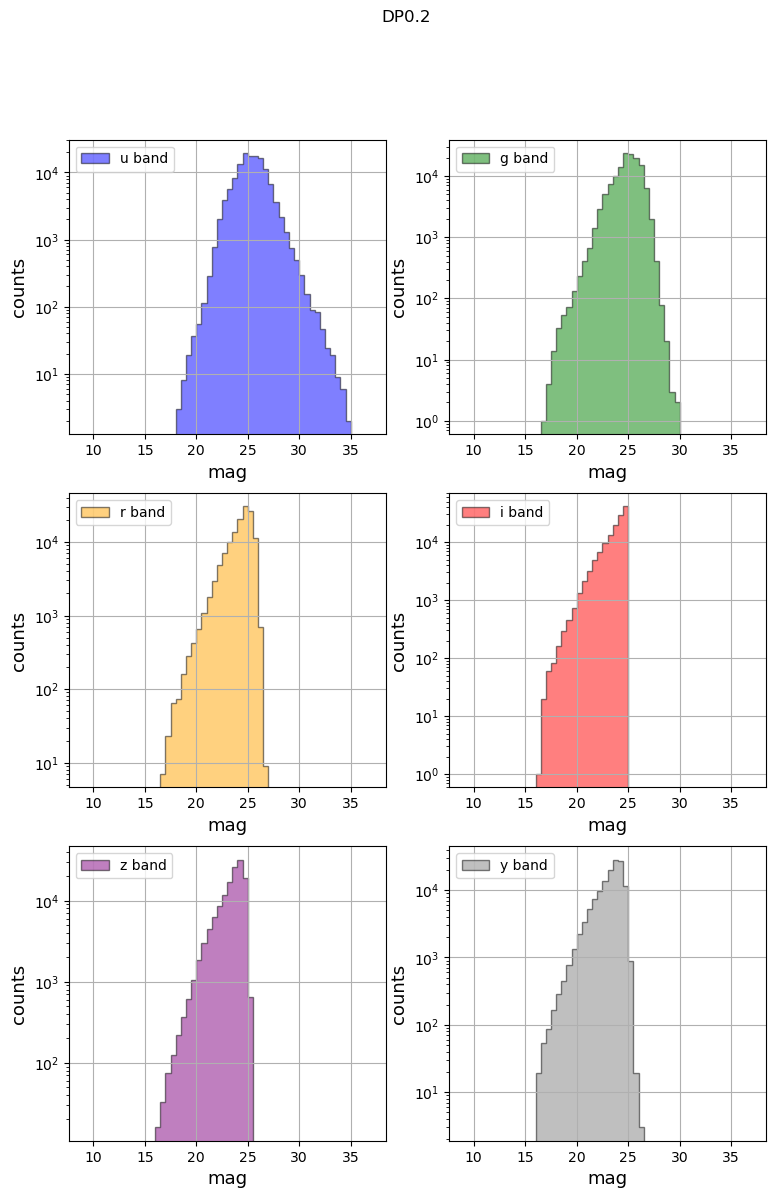

In [76]:
mag_histogram(data)

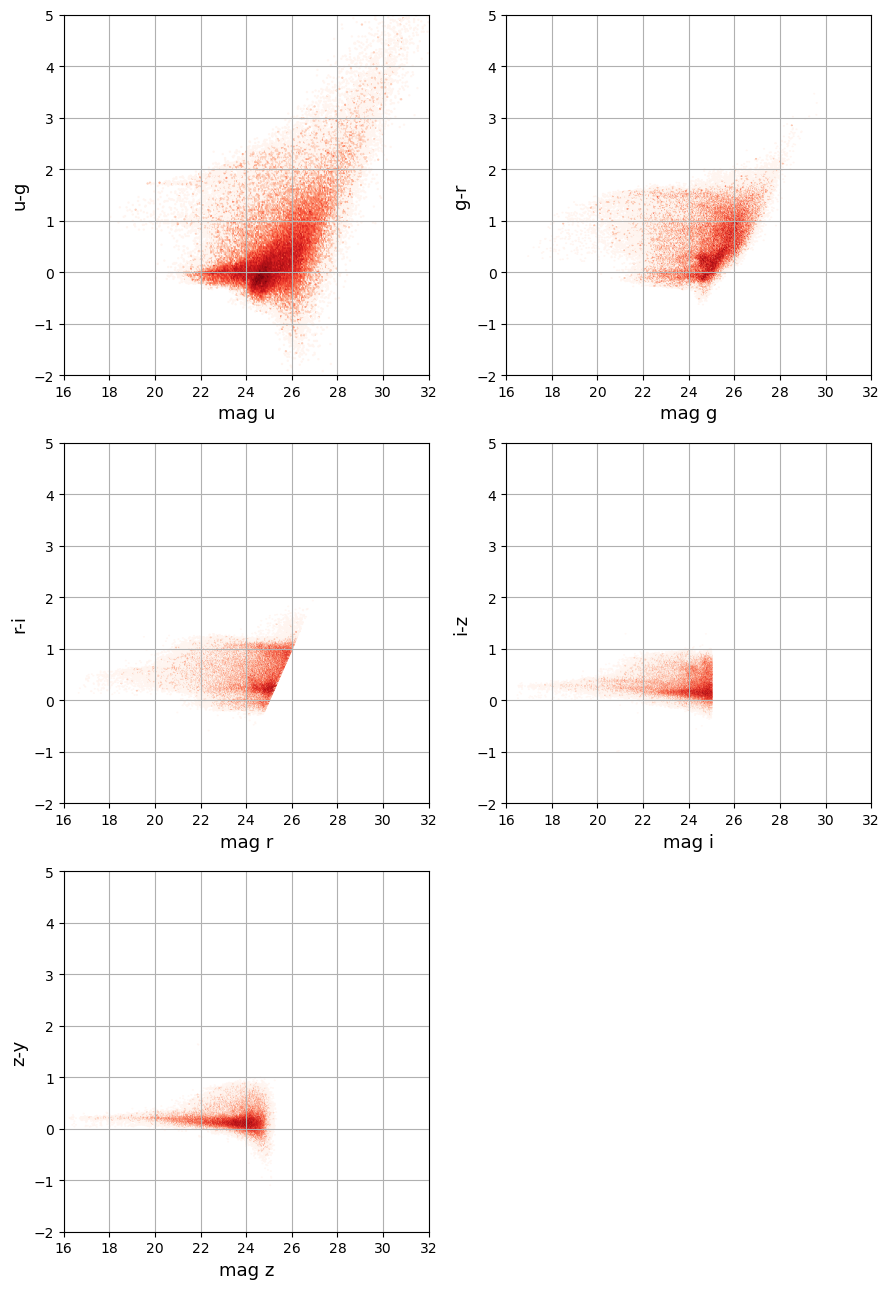

In [77]:
mag_color(data)

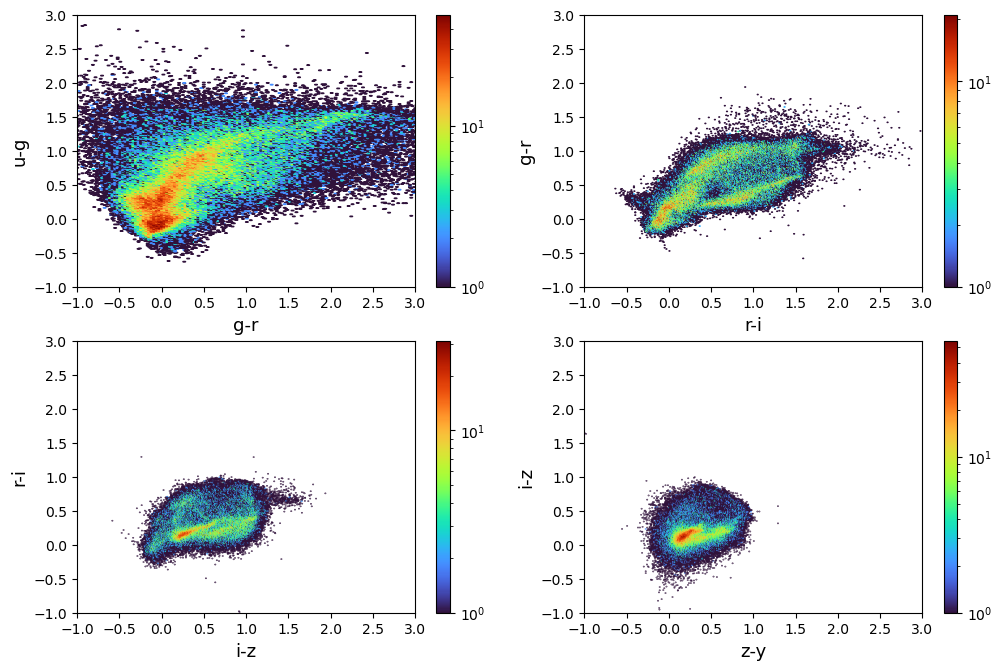

In [78]:
color_color(data)

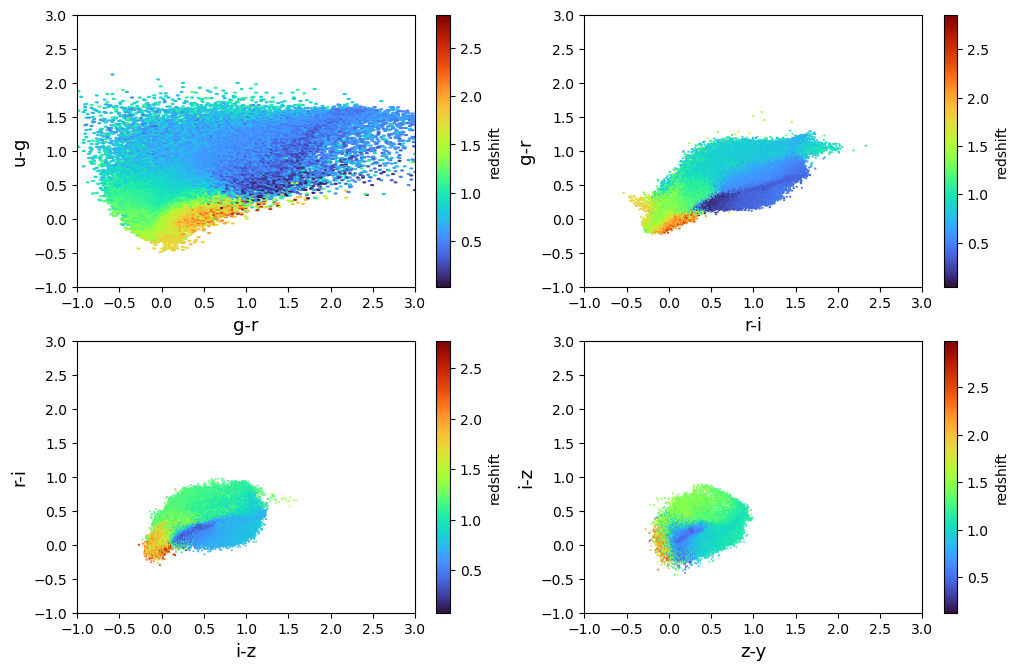

In [84]:
color_color_red(data)

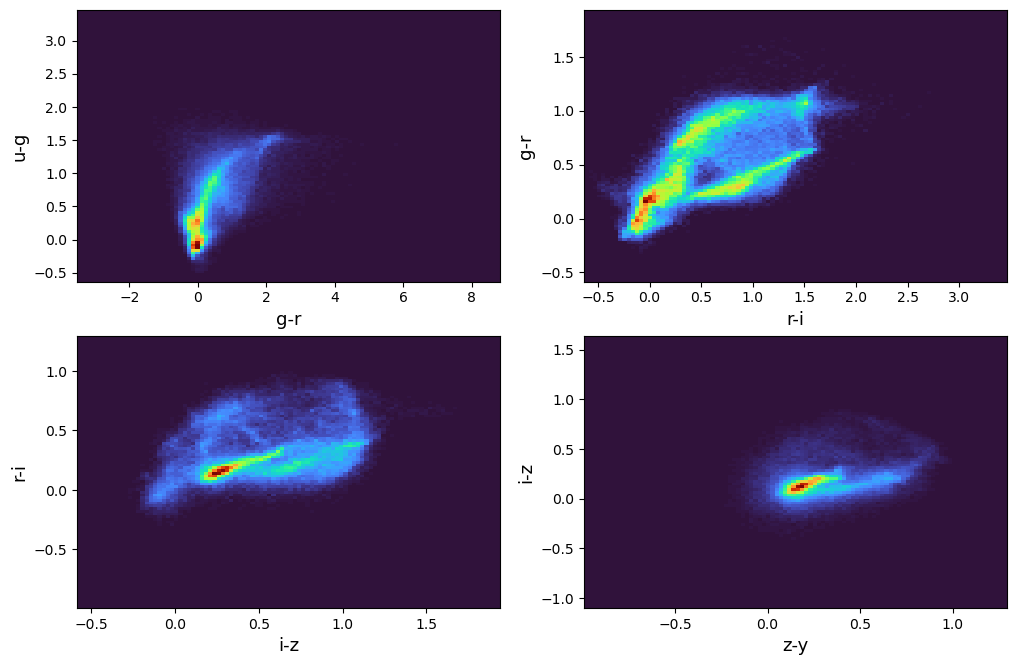

In [79]:
cor_cor(data)